We performe sensitivity analyses for data preprocessing in predicting the spread using GPR for prediction in Example~2. 

1. Instead of leveraging a fixed window of 30, we conducted a sensitivity analysis by varying the averaging window lengths for data-preprocessing for GPR training and prediction. The smoothing window for data preprocessing is draw from the set $\{1,3,5,10,20,30,50\}$, where we fix $\eta = 7$. The GPR prediction results are given by the following code and figures.

<>:106: SyntaxWarning: invalid escape sequence '\D'
<>:106: SyntaxWarning: invalid escape sequence '\D'
C:\Users\bshe6\AppData\Local\Temp\1\ipykernel_20396\3568496347.py:106: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta_7$', fontsize=35)


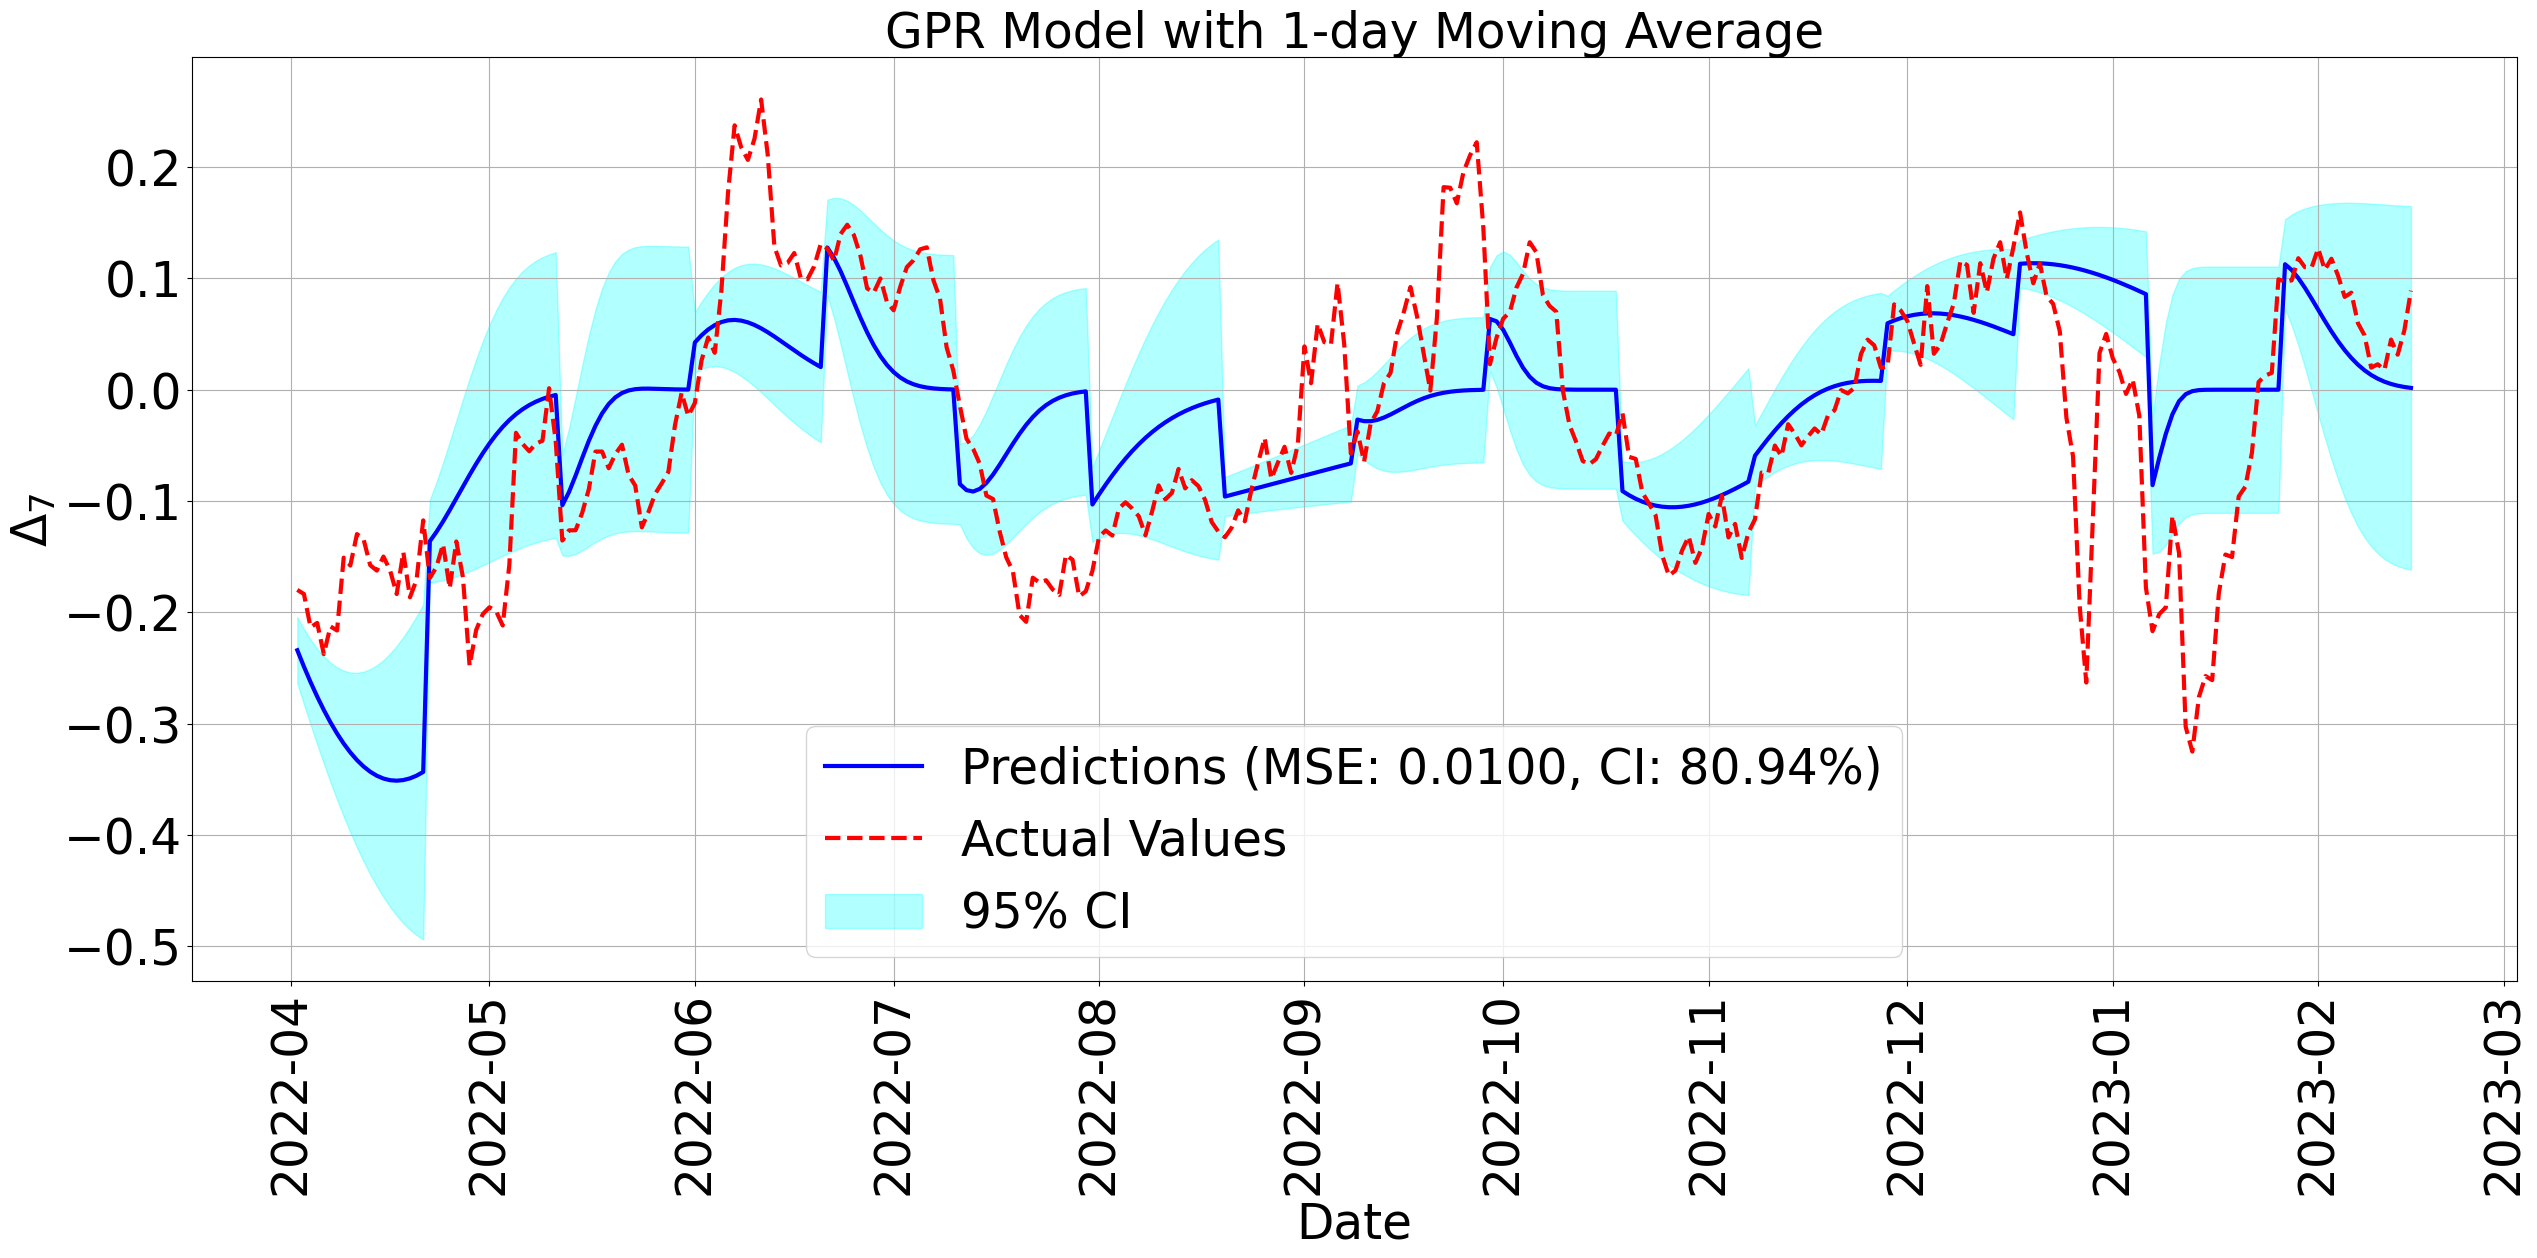

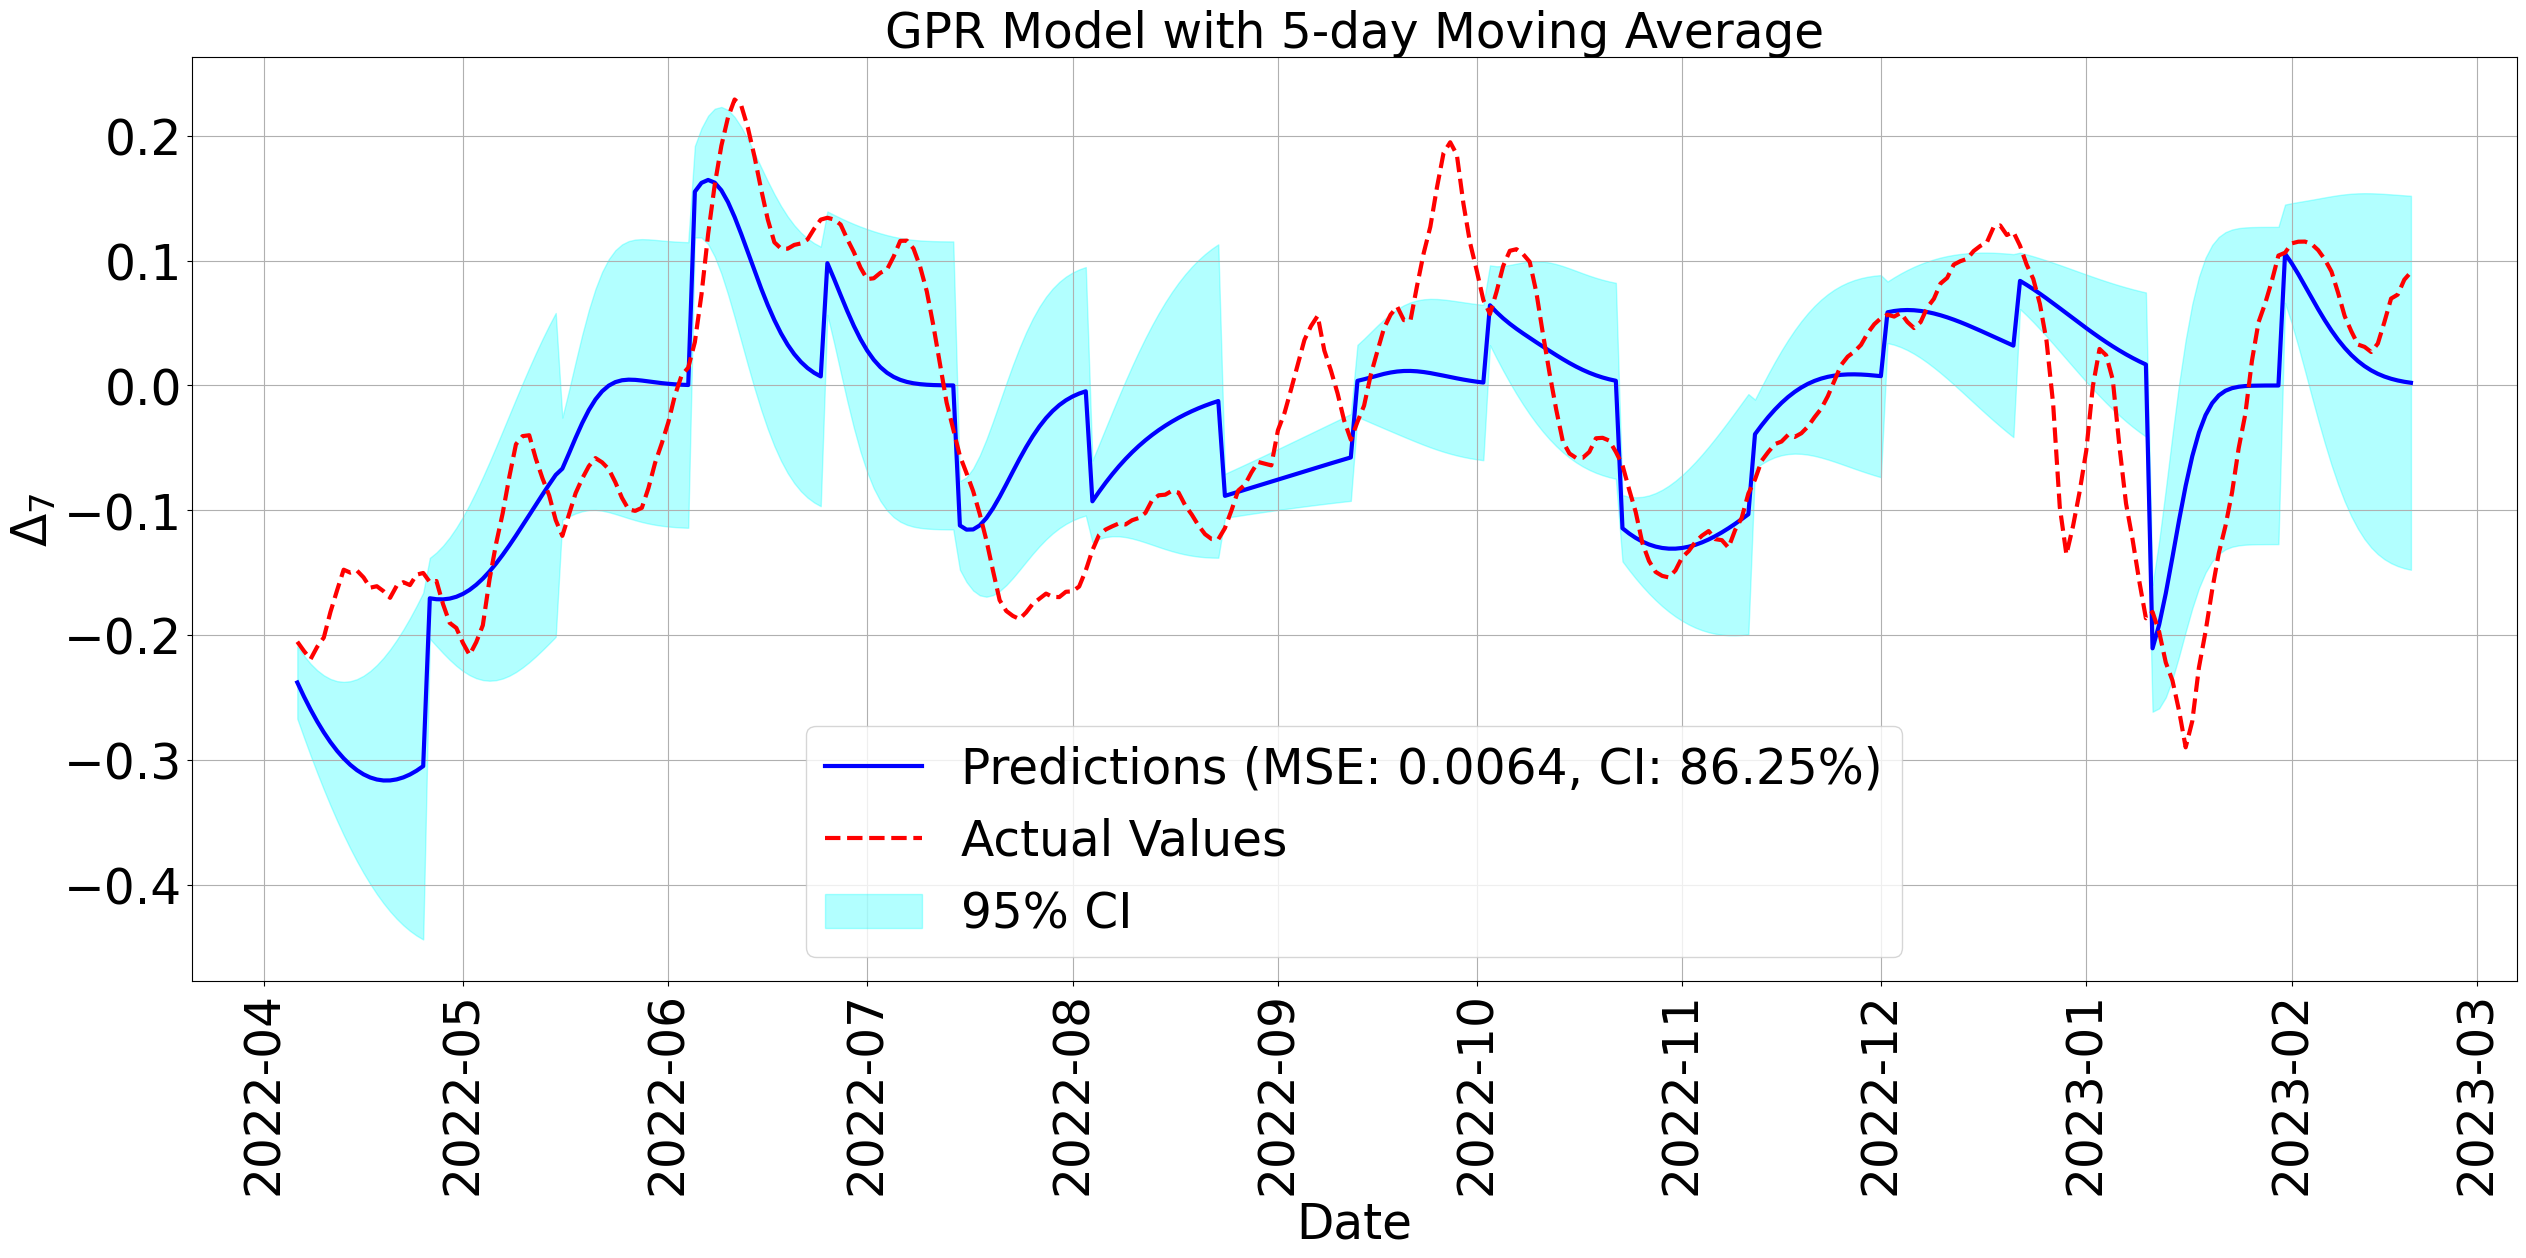

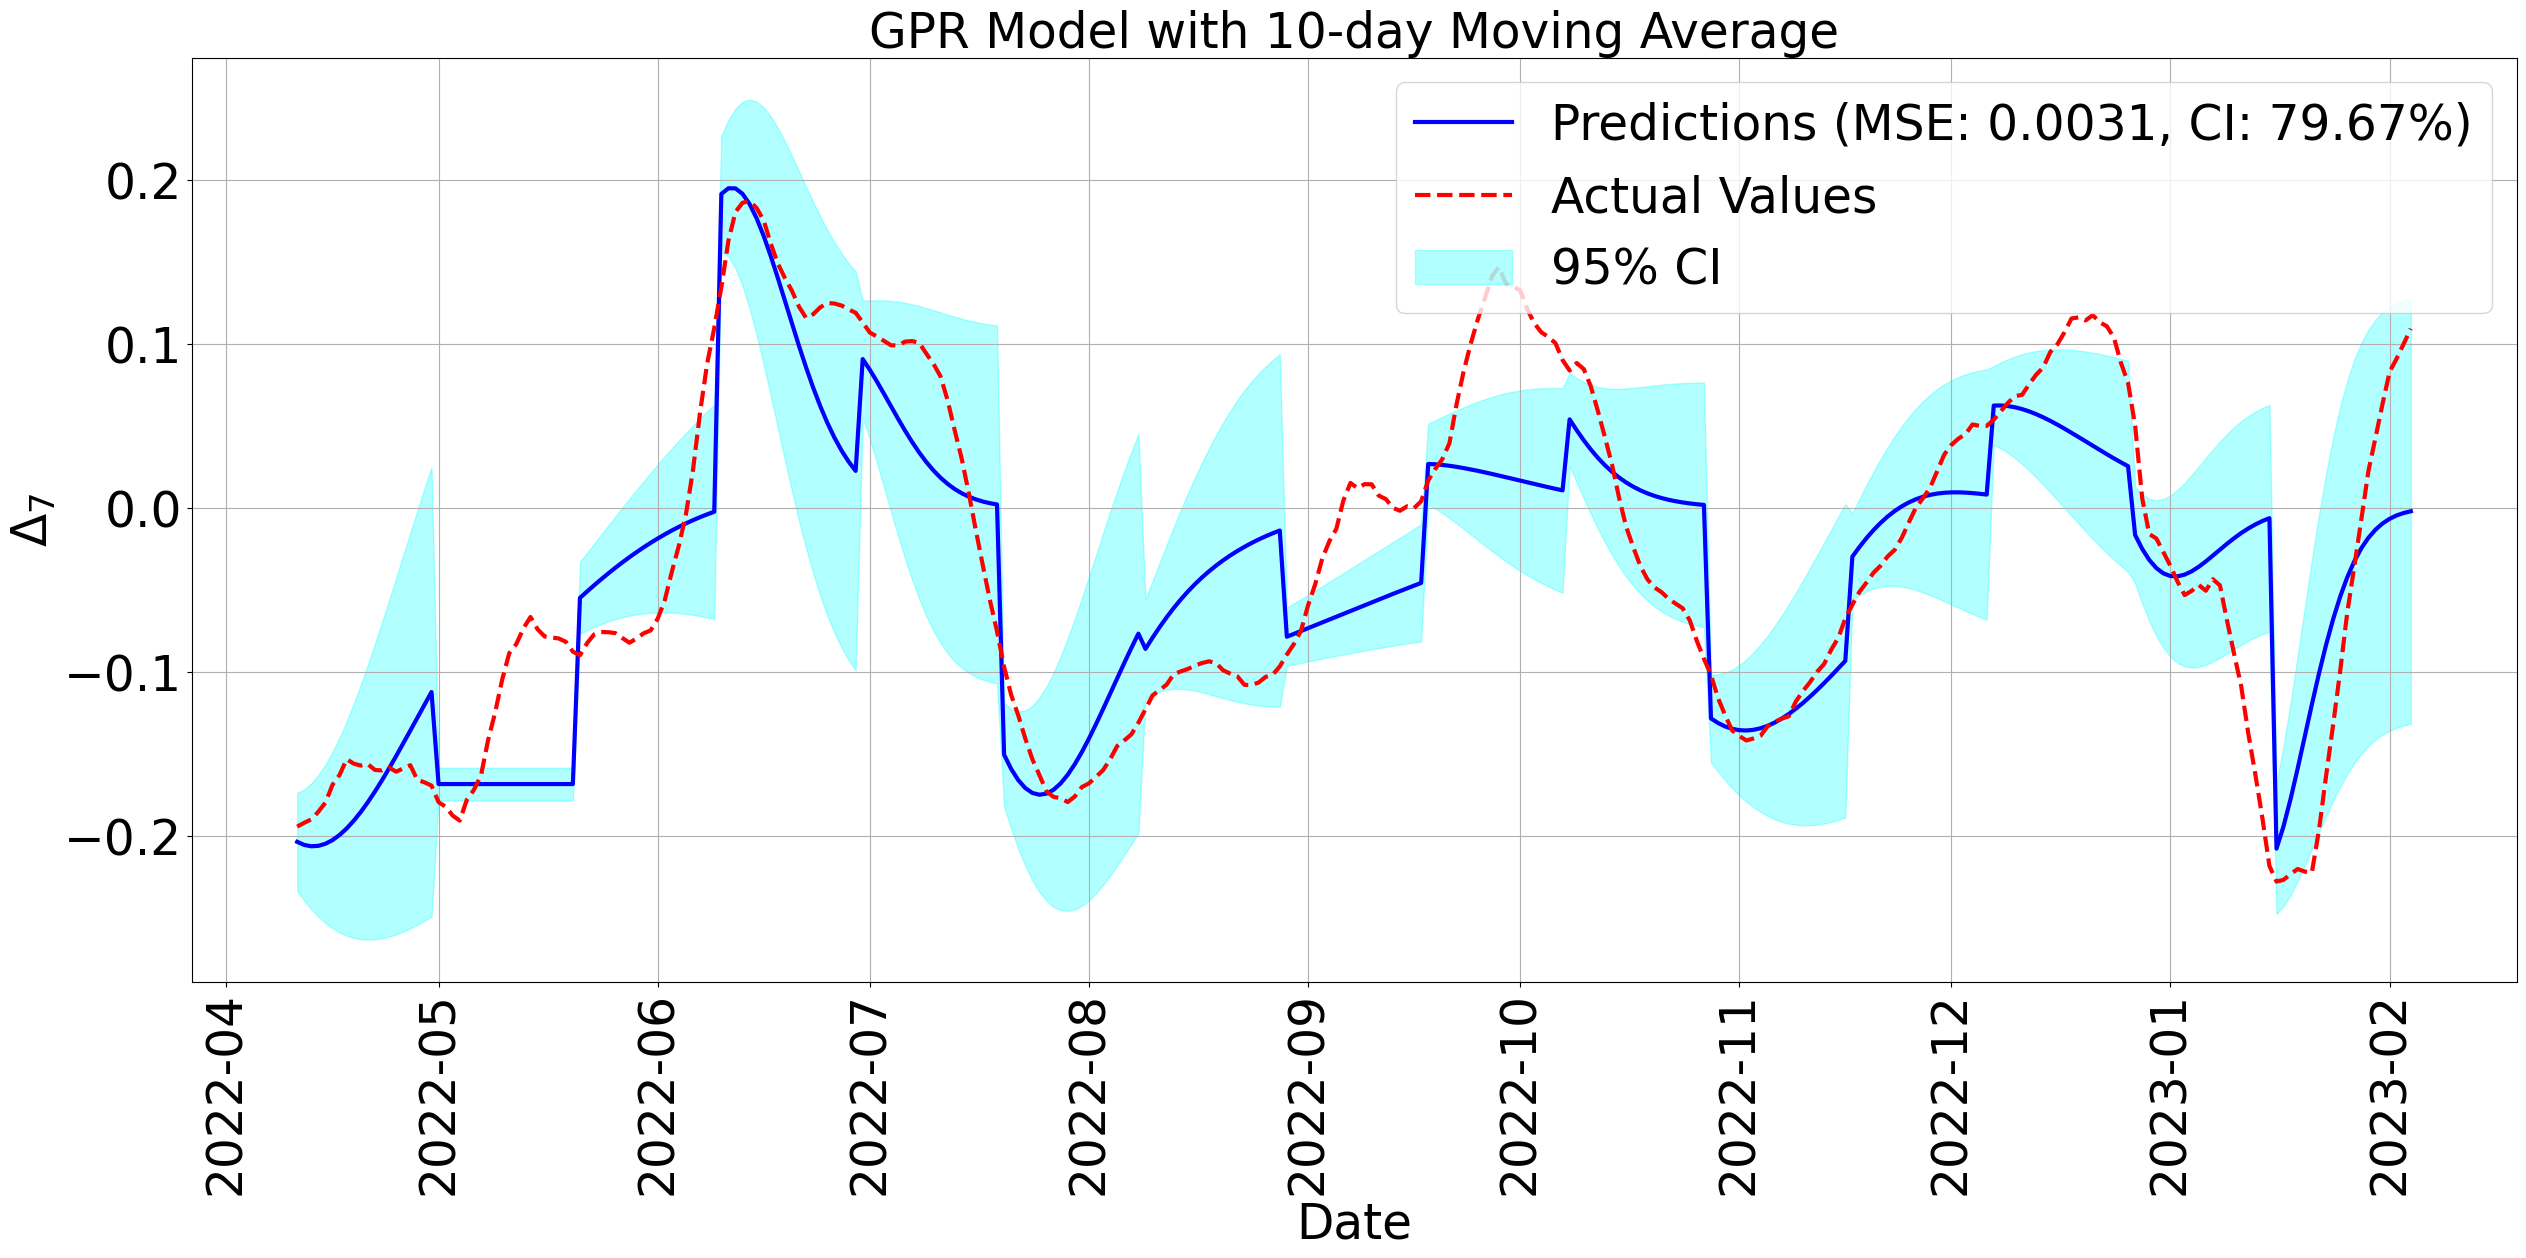

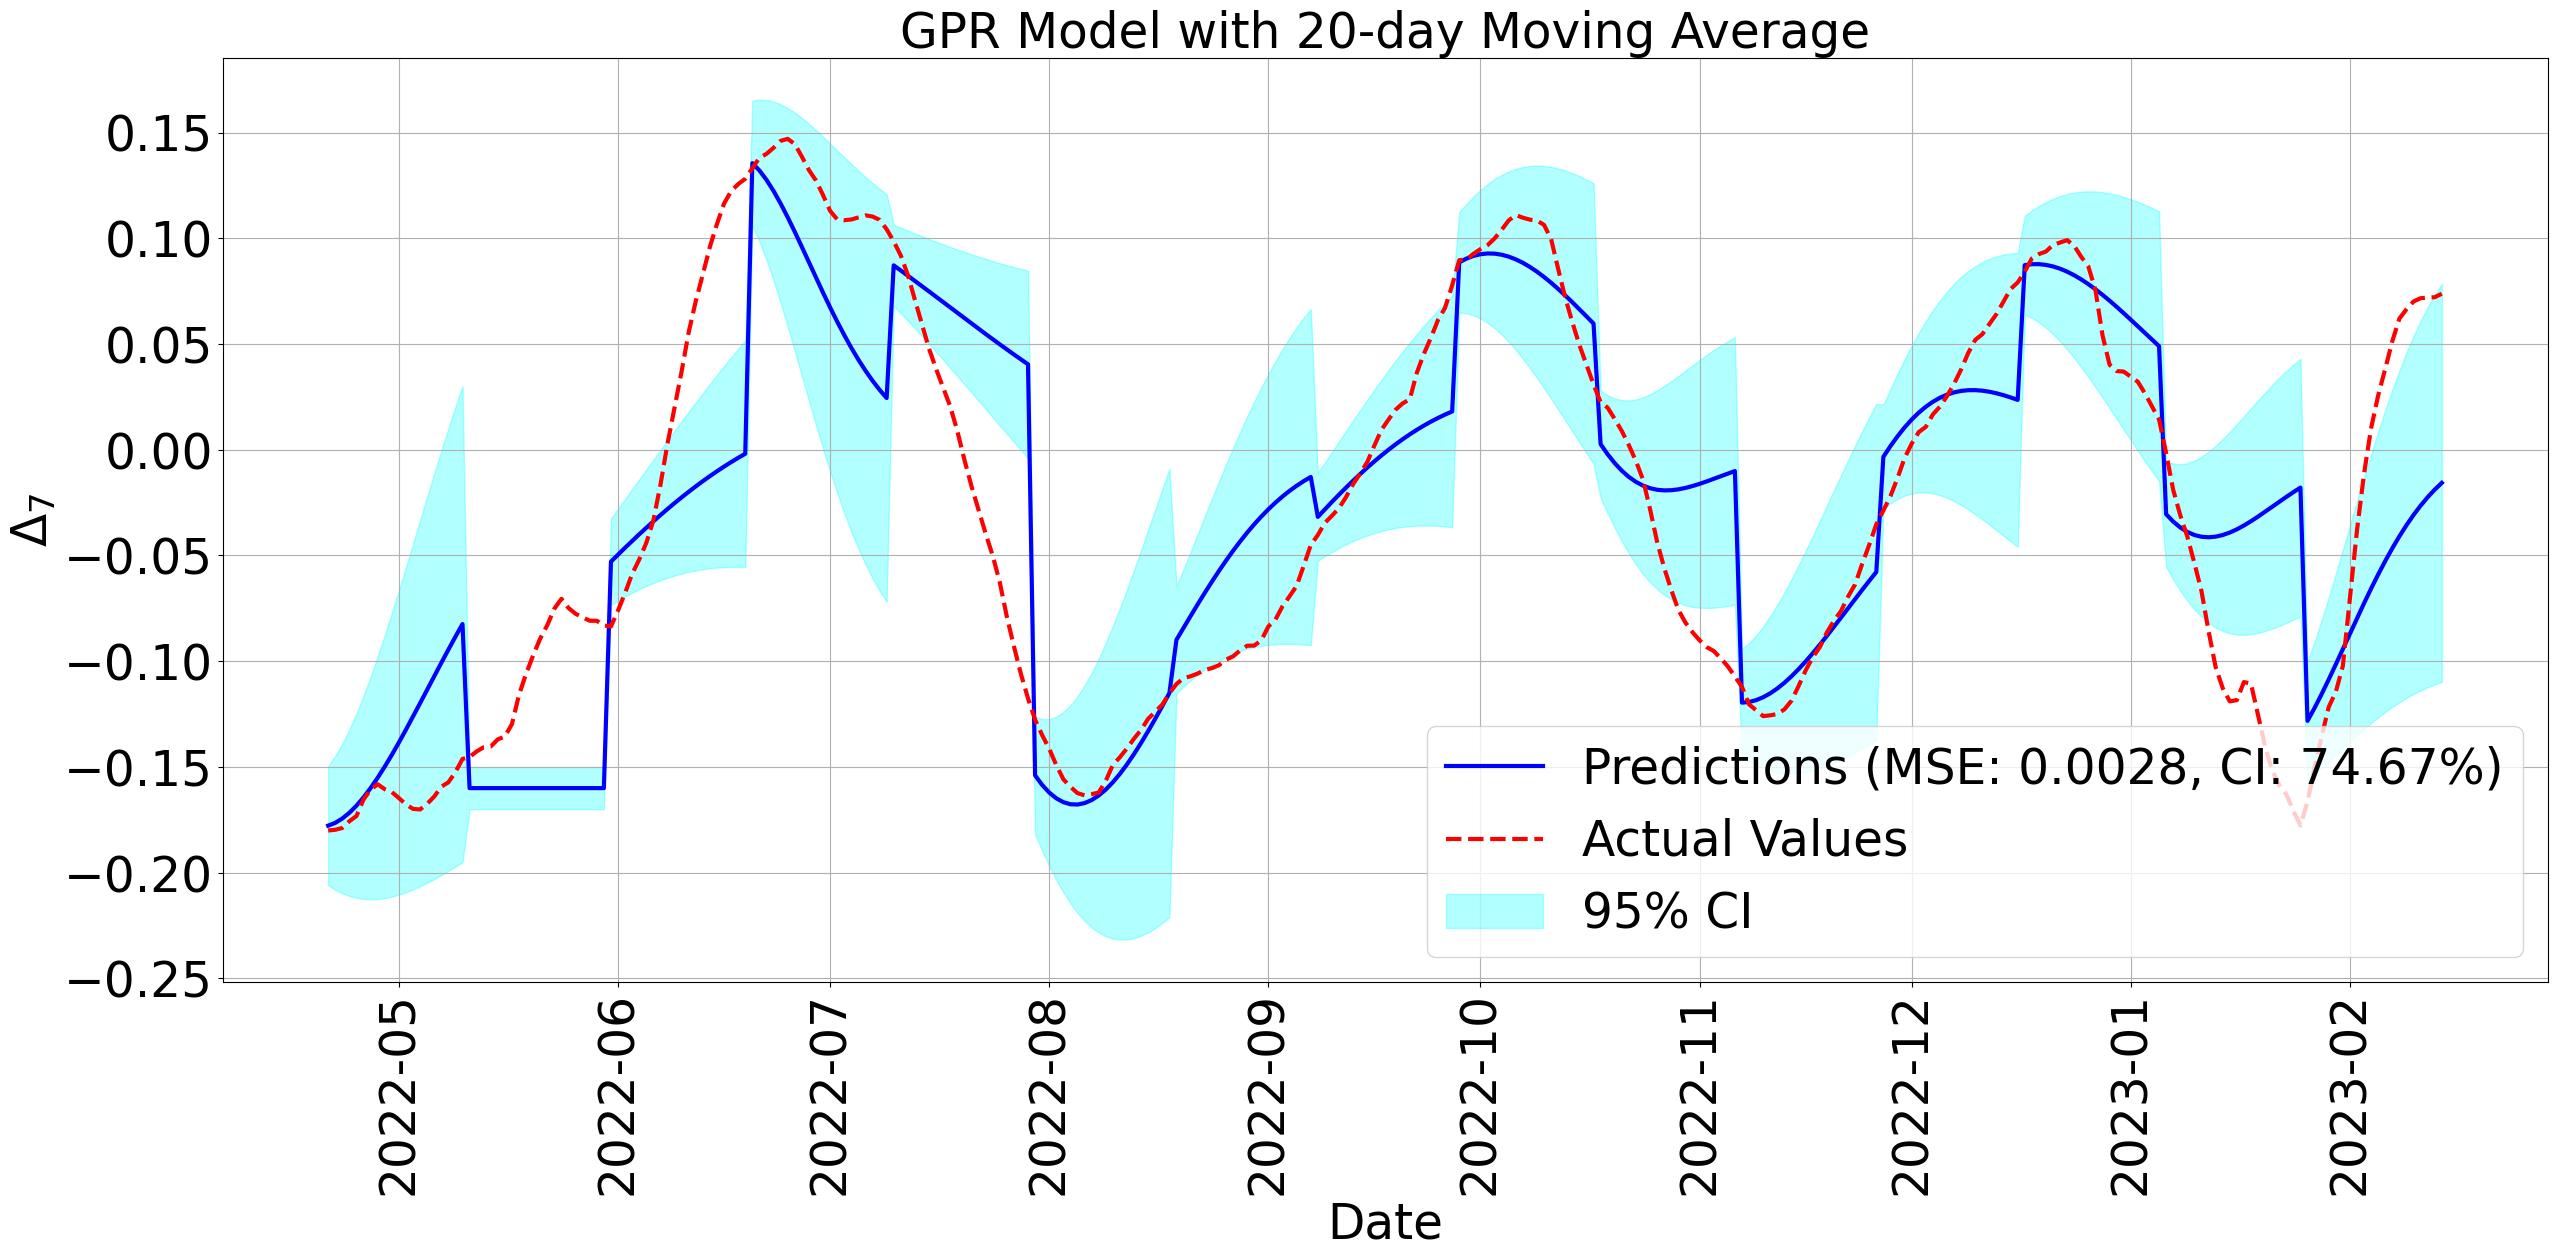

In [5]:
import numpy as np
import gpflow
from gpflow.kernels import SquaredExponential
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pandas as pd

# Load the dataset
data_path = 'UK_2022_2023.csv'  # Replace with the correct path
data_df = pd.read_csv(data_path)
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%m/%d/%Y')

# Window sizes for moving average
window_sizes = [1, 3, 5, 10, 20, 30, 50]

# Parameters
T = 1
tau = 2.5
delta = 0.05
sigma_squared = 0.003

# Loop through each window size and plot results
for window_size in window_sizes:
    temp_df = data_df.copy()
    temp_df['Cases_MA'] = temp_df['Cases'].rolling(window=window_size).mean()
    temp_df['Delta_7'] = np.log10(temp_df['Cases_MA']) - np.log10(temp_df['Cases_MA'].shift(7))
    temp_df = temp_df.dropna(subset=['Delta_7'])  # Remove NaN values after moving average
    
    data = temp_df['Delta_7'].values
    dates = temp_df['Date'].values
    
    # Initialize lists to store results
    all_means = []
    all_variances = []
    mean_indices = []
    within_95_ci_count = 0
    total_predictions = 0

    # Compute gamma
    gamma = 2 * (np.log(T / (2 * tau * delta)) + 1 / delta)

    # Train and predict using an increasing window size with 30 training data points each time
    for start_idx in range(30, len(data) - 20, 20):  # Moving window of size 20
        train_idx = np.arange(start_idx - 30, start_idx)
        test_idx = np.arange(start_idx, start_idx + 20)
        
        X_train = train_idx.reshape(-1, 1).astype(np.float64)
        Y_train = data[train_idx].reshape(-1, 1).astype(np.float64)
        
        X_test = test_idx.reshape(-1, 1).astype(np.float64)
        Y_test = data[test_idx].reshape(-1, 1).astype(np.float64)
        
        # Define the Squared Exponential kernel
        kernel = SquaredExponential()
        
        # Define the GP model
        model_I = gpflow.models.GPR(
            data=(X_train, Y_train),
            kernel=kernel,
            likelihood=gpflow.likelihoods.Gaussian(variance_lower_bound=sigma_squared)
        )
        
        # Set up the optimizer
        opt = gpflow.optimizers.Scipy()
        
        # Train the model
        opt.minimize(model_I.training_loss, model_I.trainable_variables)
        
        # Predict at the test locations
        I_mean, I_var = model_I.predict_f(X_test)
        
        # Store the means and variances for plotting
        all_means.append(I_mean.numpy().flatten())
        all_variances.append(np.sqrt(I_var.numpy().flatten()))
        mean_indices.extend(test_idx - 5)  # Shift predictions back by 5 dates to align
        
        # Compute 95% confidence intervals and count predictions within them
        for i in range(len(test_idx)):
            lower_bound = I_mean.numpy()[i, 0] - 1.96 * np.sqrt(I_var.numpy()[i, 0])
            upper_bound = I_mean.numpy()[i, 0] + 1.96 * np.sqrt(I_var.numpy()[i, 0])
            total_predictions += 1
            if lower_bound <= Y_test[i, 0] <= upper_bound:
                within_95_ci_count += 1

    # Convert lists to arrays
    all_means = np.concatenate(all_means)
    all_variances = np.concatenate(all_variances)
    mean_indices = np.array(mean_indices)

    # Compute MSE between predictions and actual values
    actual_values = data[mean_indices]
    mse = mean_squared_error(actual_values, all_means)
    
    # Compute percentage of predictions within 95% confidence intervals
    within_95_ci_percentage = (within_95_ci_count / total_predictions) * 100
    
    # Plotting the prediction and true values
    plt.figure(figsize=(30, 12))
    plt.plot(dates[mean_indices], all_means, color='blue', label=f'Predictions (MSE: {mse:.4f}, CI: {within_95_ci_percentage:.2f}%)', linewidth=3)
    plt.plot(dates[mean_indices], actual_values, color='red', linestyle='--', label='Actual Values', linewidth=3)
    
    # Plotting confidence intervals
    plt.fill_between(dates[mean_indices], all_means - all_variances, all_means + all_variances, color='cyan', alpha=0.3, label='95% CI')
    
    plt.xlabel('Date', fontsize=35)
    plt.ylabel('$\Delta_7$', fontsize=35)
    plt.title(f'GPR Model with {window_size}-day Moving Average', fontsize=35)
    plt.xticks(rotation=90, fontsize=35)
    plt.yticks(fontsize=35)
    plt.legend(fontsize=35)
    plt.grid(True)
    
    # Save the plot
    plt.savefig(f'GPR_Model_{window_size}_Day_MA_Shifted.png', dpi=300, bbox_inches='tight')
    plt.show()


Summary: 

According to the simulation results, we used window sizes of $1$, $3$, and $5$. For these window sizes, the prediction accuracy was $80.94\%$, $83.12\%$ , and $86.25\%$, with corresponding MSE values of $0.0100$, $0.0087$, and $0.0064$, respectively. 
We also experimented with smoothing window sizes of $10$, $20$, $30$, and $50$. The prediction accuracy for these windows was $79.67\%$, $74.67\%$ , and $94.29\%$, and $73.46\%$ with corresponding MSE values of $0.0031$, $0.0028$, $0.0011$ and $0.0009$, respectively. We have the following summary about the prediction results.

- Short Smoothing Windows (1, 3, 5 days): Shorter smoothing windows retain much of the data's short-term variability. This allows the GPR model to capture and adapt to rapid changes or fluctuations in the time-series data, leading to improved short-term predictions. However, if the window is too short, the model may overfit to noise rather than the true underlying trend, limiting its ability to generalize to unseen data. This is why even smaller windows (like 1 day) may still result in suboptimal prediction.

- Moderate Smoothing Windows (10, 20 days): These window sizes may filter out too much short-term variability while still not fully capturing the longer-term periodic patterns. The model can struggle to find a balance, missing some important details necessary for accurate predictions. The smoothed data using these window sizes might show incomplete or mixed trends, which can confuse the GPR, resulting in less reliable predictions and result in lower prediction accuracy.

- Optimal Smoothing Window (30 days): A 30-day smoothing window provides the right balance between filtering out short-term noise and capturing long-term patterns, including periodic trends in disease spread. This leads to more stable and accurate predictions. With a 30-day window, the underlying periodic behavior (such as monthly trends in the spread of disease) becomes clearer. This helps the GPR model learn and extrapolate these patterns effectively, enhancing prediction accuracy.

- Long Smoothing Windows (50 days): A longer smoothing window excessively suppresses short-term variations, overemphasizing long-term trends. This reduces the model's flexibility and sensitivity to recent changes in the data, causing poorer predictions, particularly when abrupt changes occur.


2. We conduct a sensitivity analysis on data preprocessing using a fixed 30-day smoothing window while varying the length of the log-difference on infected cases, where $\eta$ was selected from the set $\{3,7,14,21,28\}$. The results are presented in the following code and figures.

<>:109: SyntaxWarning: invalid escape sequence '\D'
<>:109: SyntaxWarning: invalid escape sequence '\D'
C:\Users\bshe6\AppData\Local\Temp\1\ipykernel_20396\1583908788.py:109: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta_7$', fontsize=35)


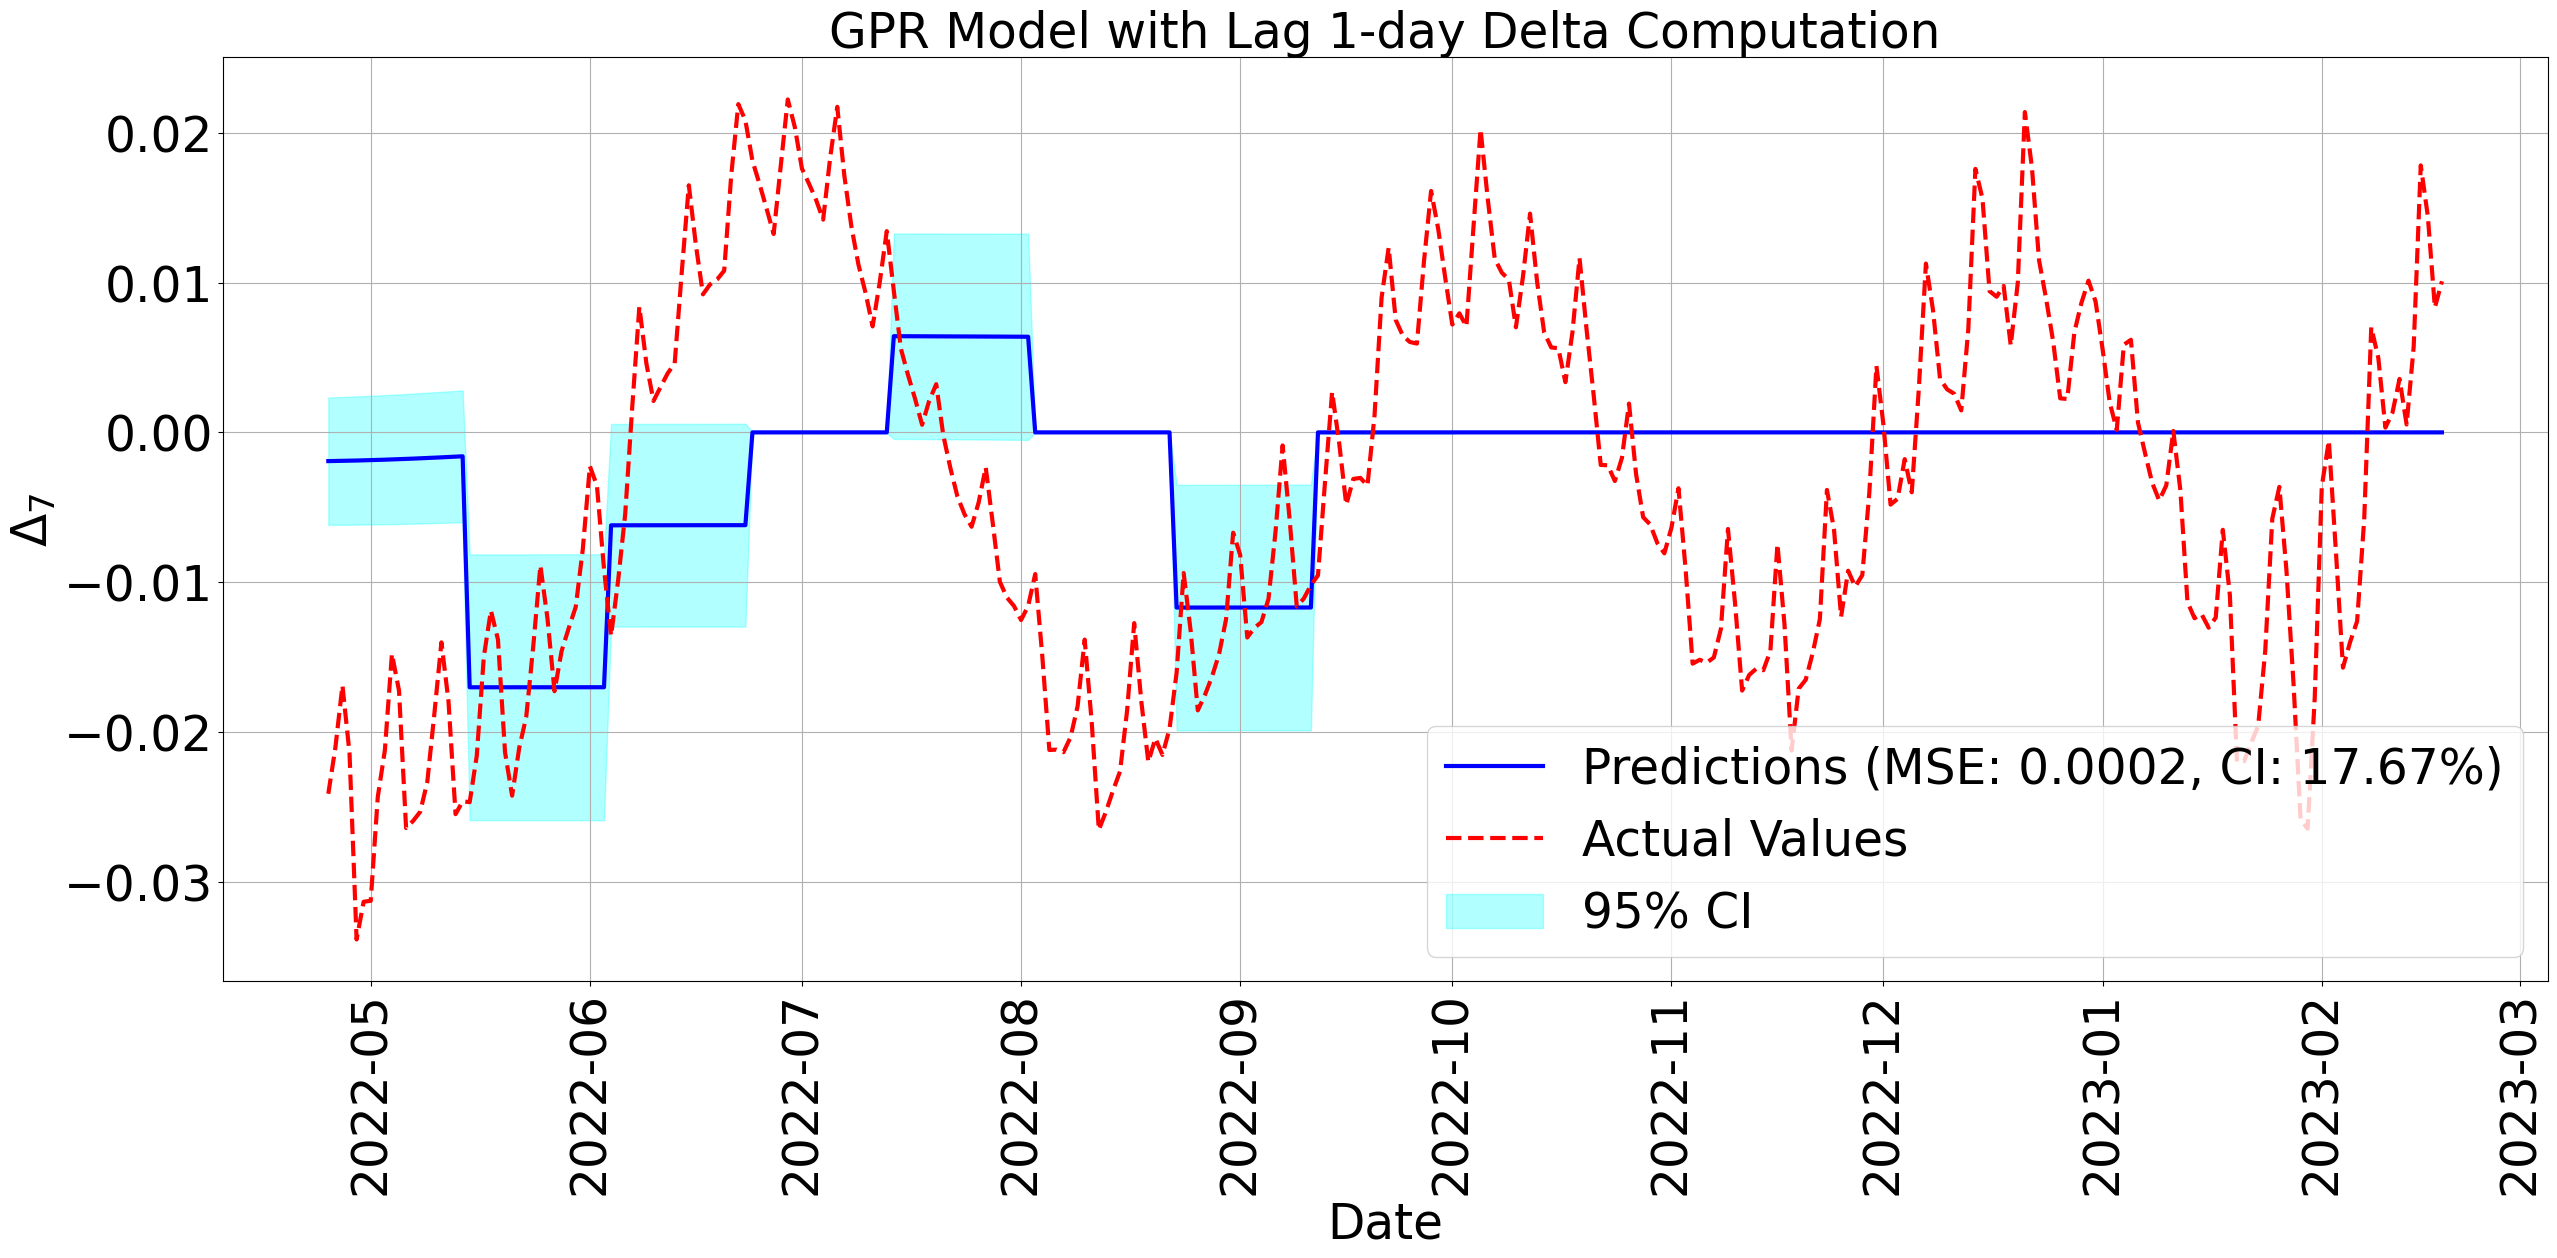

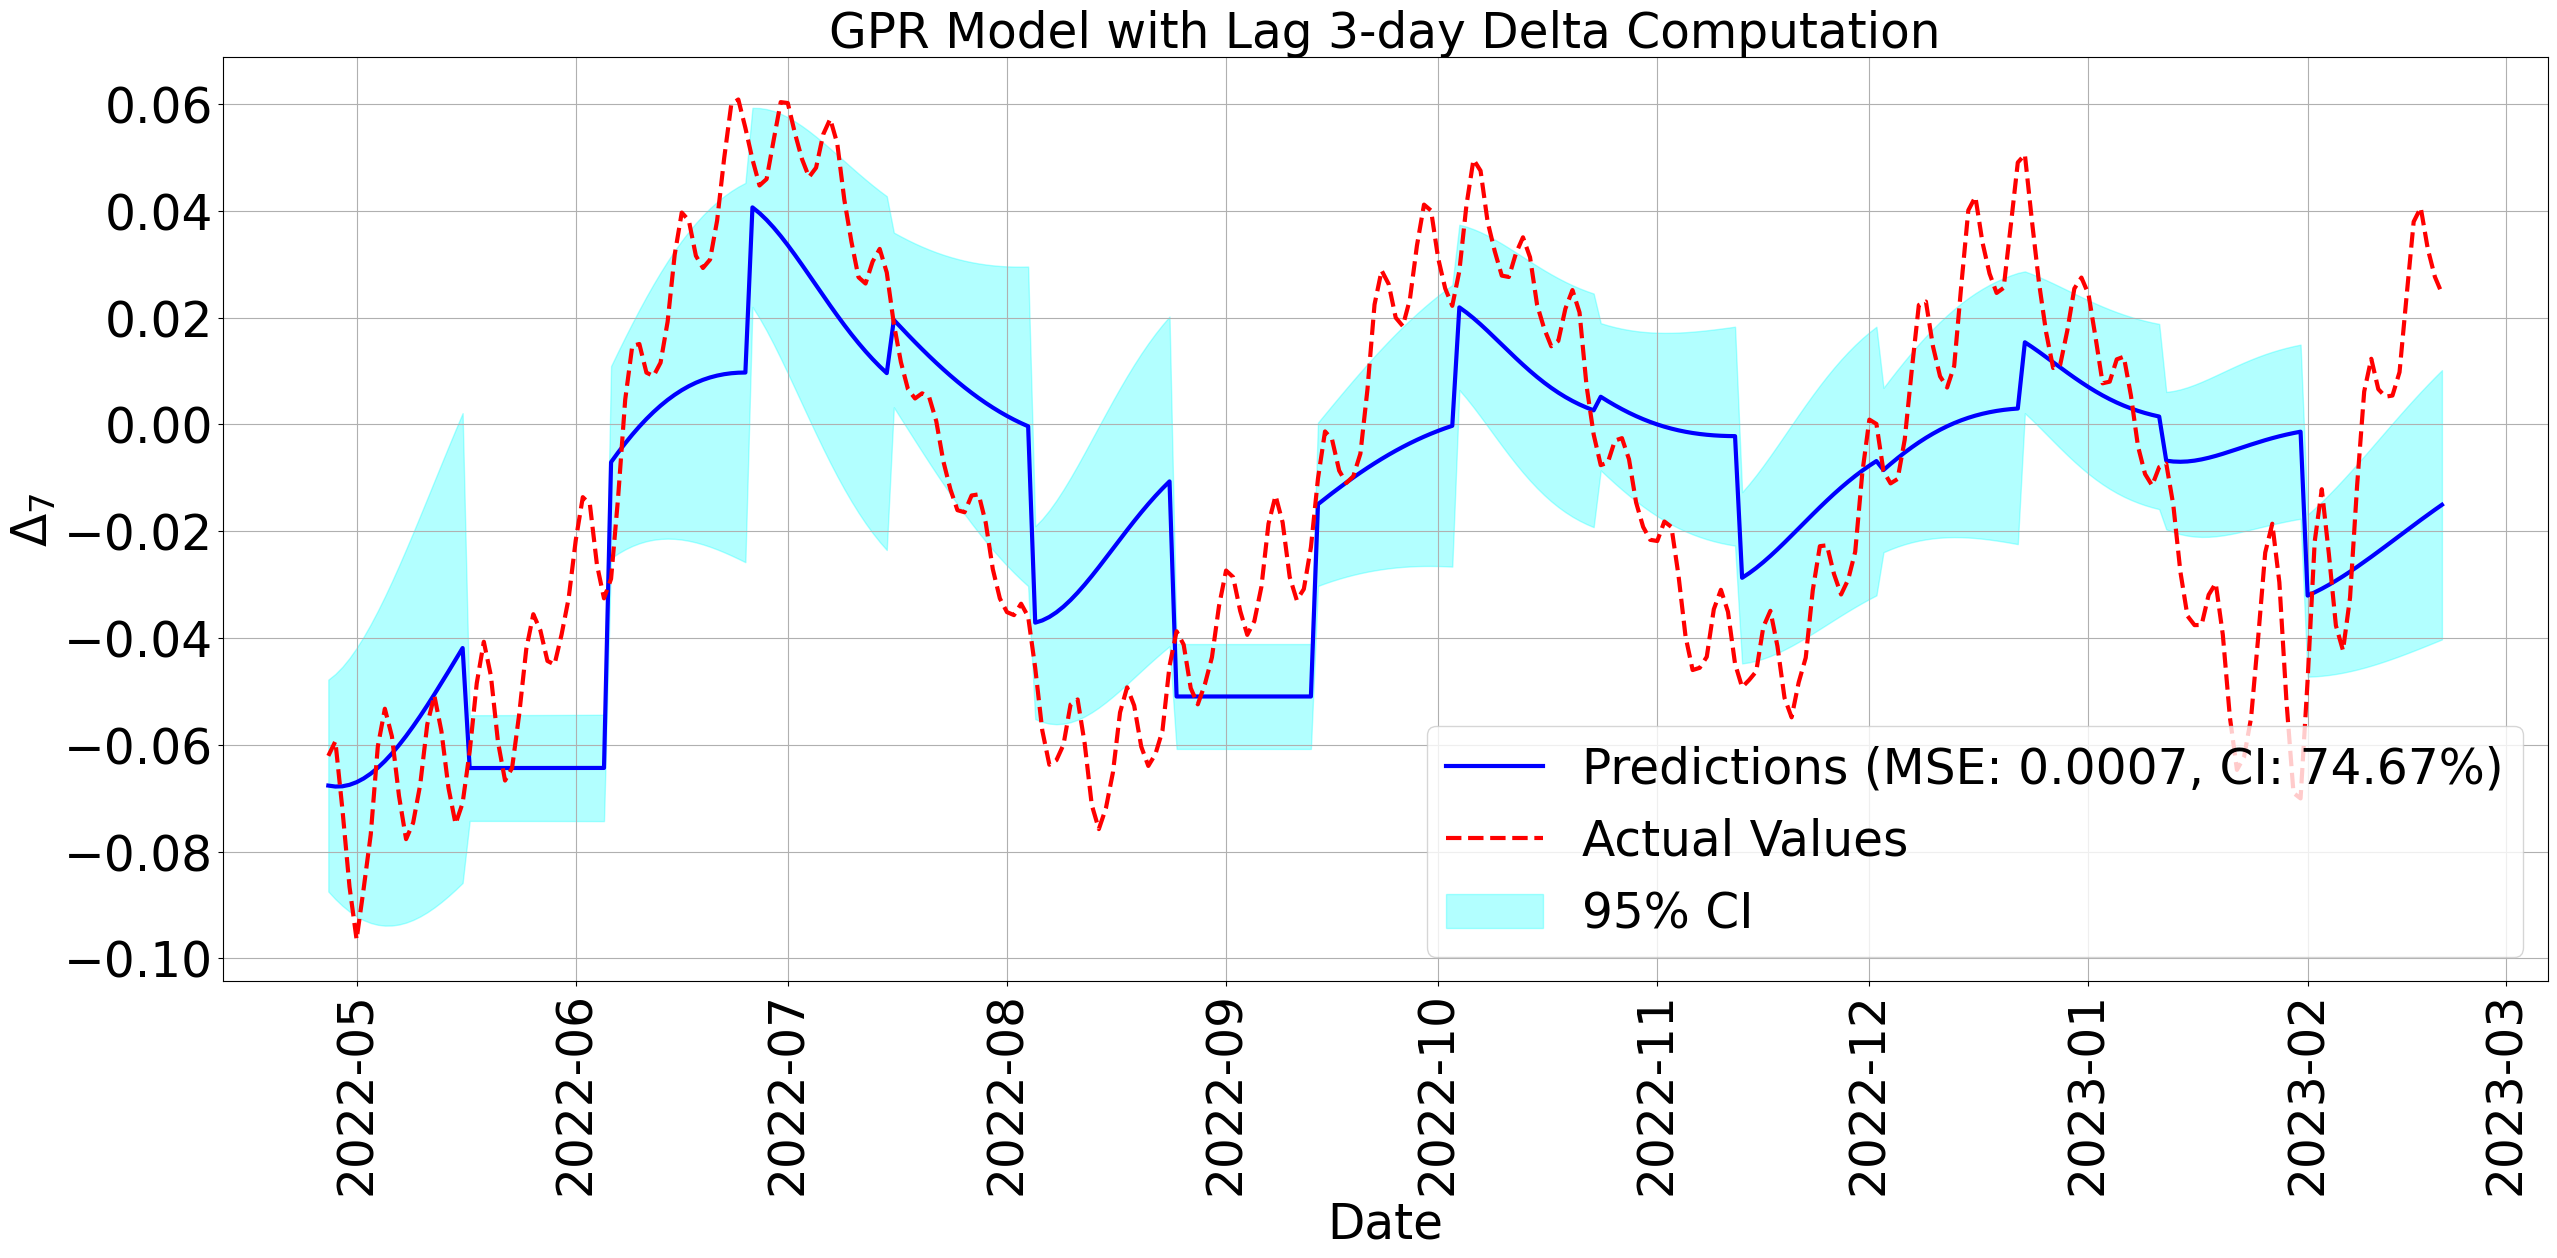

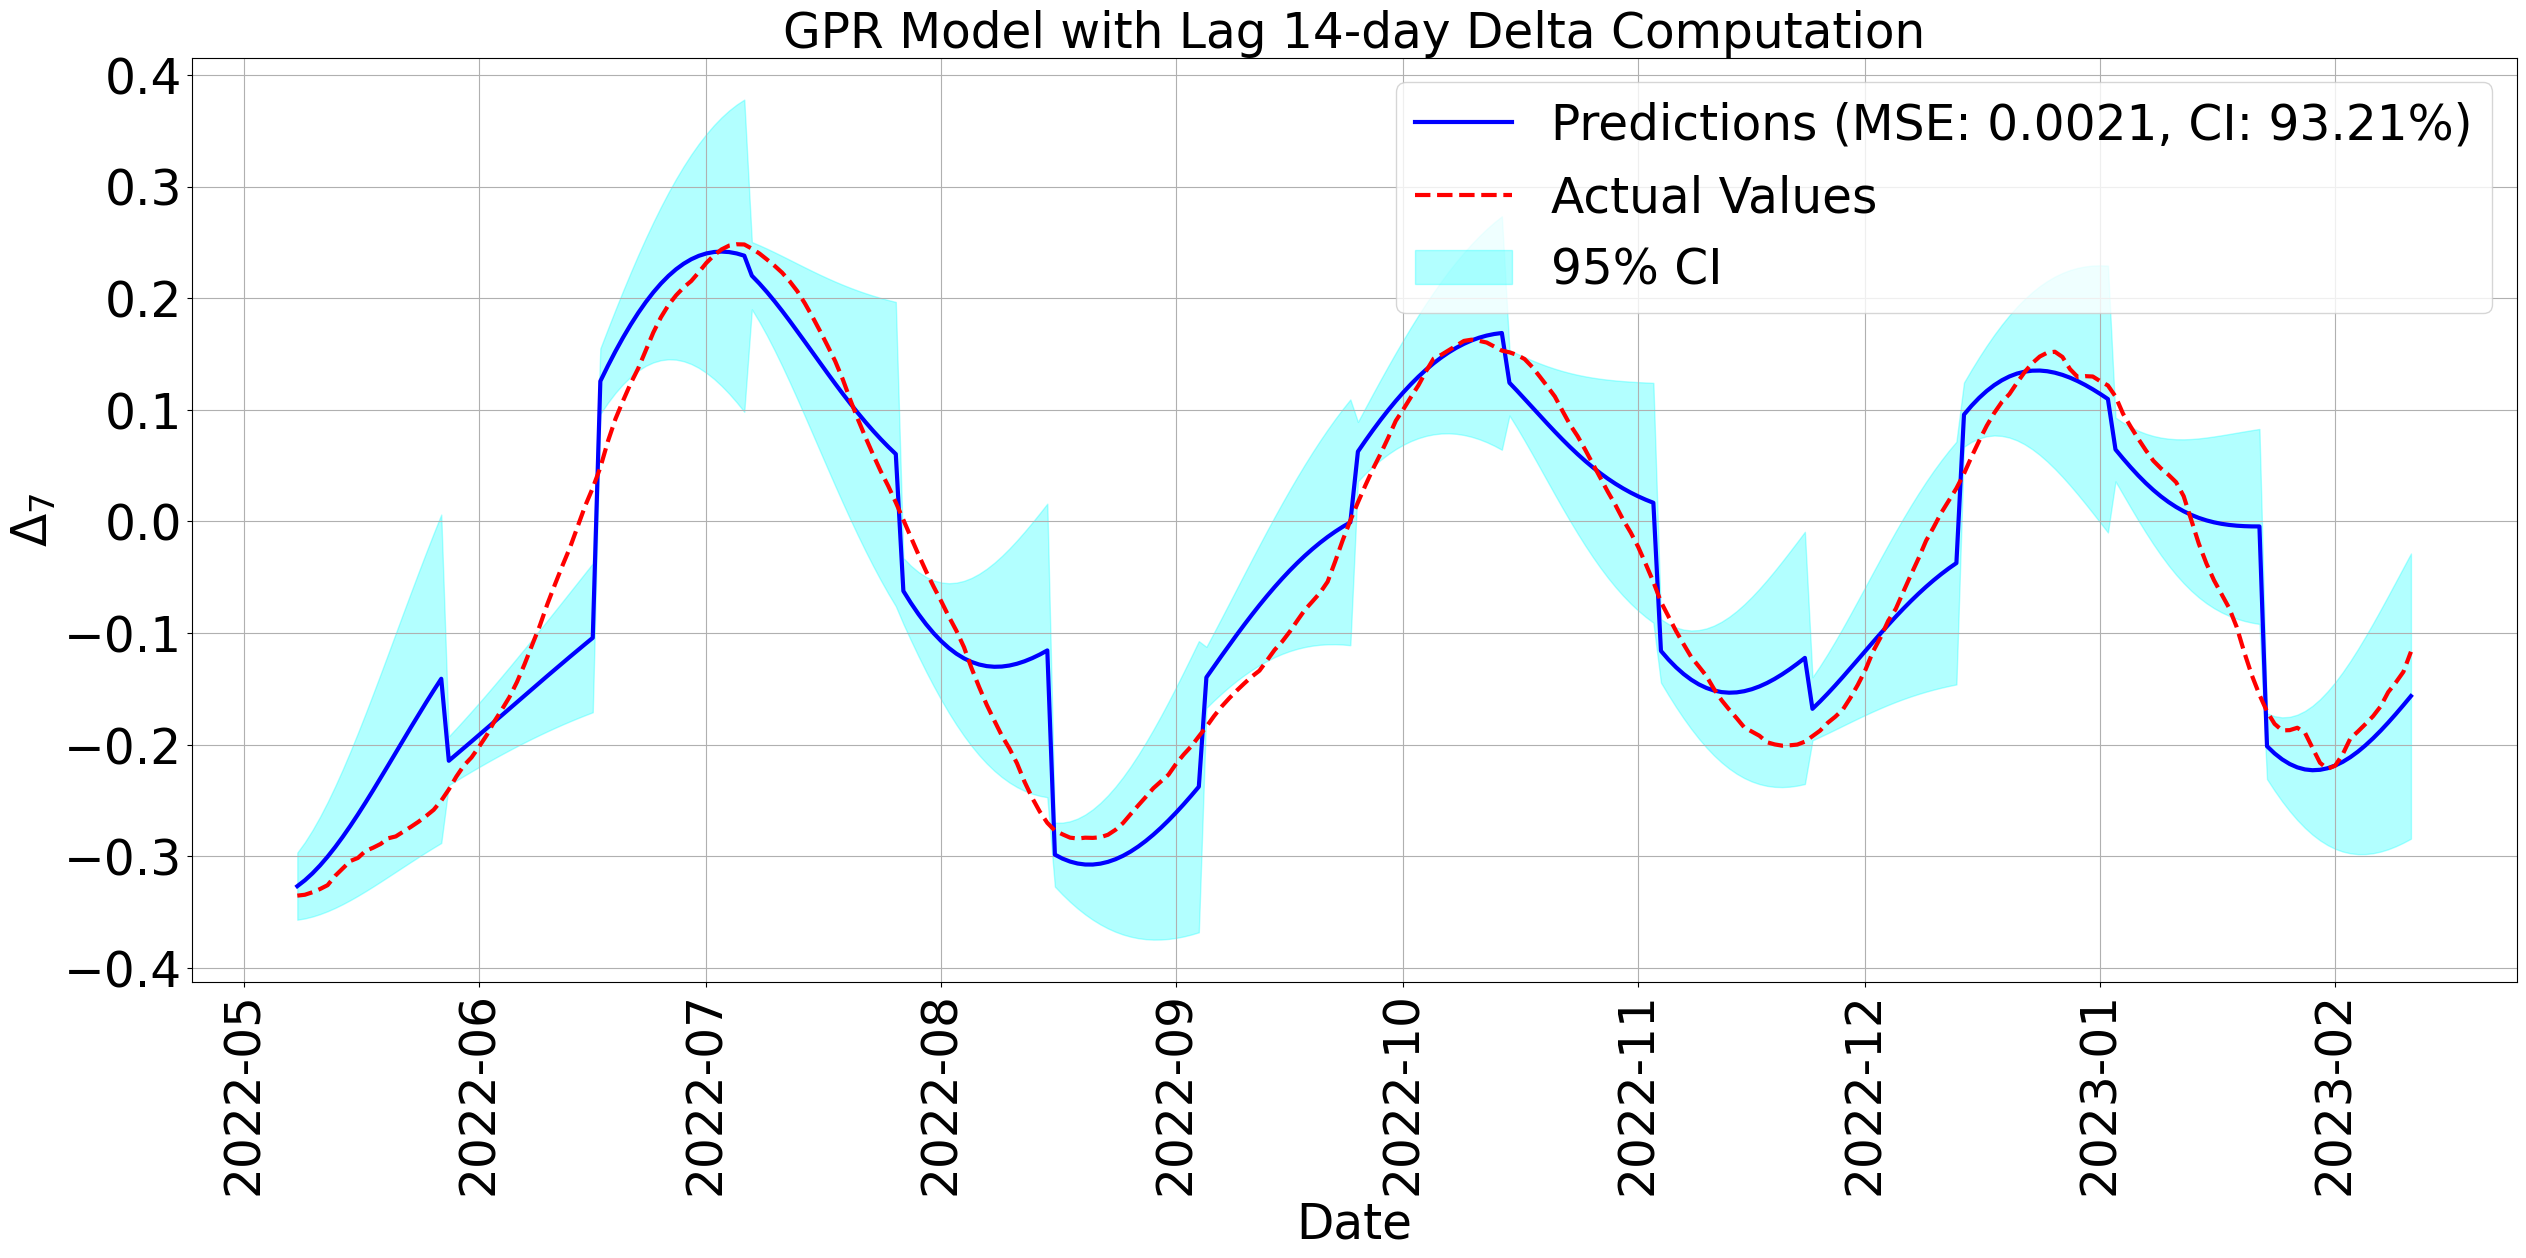

In [6]:
import numpy as np
import gpflow
from gpflow.kernels import SquaredExponential
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pandas as pd

# Load the dataset
data_path = 'UK_2022_2023.csv'  # Replace with the correct path
data_df = pd.read_csv(data_path)
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%m/%d/%Y')

# Fixed window size for moving average
window_size = 30

# Different lag values
lags = [1, 3, 7, 14, 21, 28]

# Parameters
T = 1
tau = 2.5
delta = 0.05
sigma_squared = 0.003

# Loop through each lag value and plot results
for lag in lags:
    temp_df = data_df.copy()
    temp_df['Cases_MA'] = temp_df['Cases'].rolling(window=window_size).mean()
    temp_df['Delta_7'] = np.log10(temp_df['Cases_MA']) - np.log10(temp_df['Cases_MA'].shift(lag))
    temp_df = temp_df.dropna(subset=['Delta_7'])  # Remove NaN values after moving average
    
    data = temp_df['Delta_7'].values
    dates = temp_df['Date'].values
    
    # Initialize lists to store results
    all_means = []
    all_variances = []
    mean_indices = []
    within_95_ci_count = 0
    total_predictions = 0

    # Compute gamma
    gamma = 2 * (np.log(T / (2 * tau * delta)) + 1 / delta)

    # Train and predict using an increasing window size with 30 training data points each time
    for start_idx in range(30, len(data) - 20, 20):  # Moving window of size 20
        train_idx = np.arange(start_idx - 30, start_idx)
        test_idx = np.arange(start_idx, start_idx + 20)
        
        X_train = train_idx.reshape(-1, 1).astype(np.float64)
        Y_train = data[train_idx].reshape(-1, 1).astype(np.float64)
        
        X_test = test_idx.reshape(-1, 1).astype(np.float64)
        Y_test = data[test_idx].reshape(-1, 1).astype(np.float64)
        
        # Define the Squared Exponential kernel
        kernel = SquaredExponential()
        
        # Define the GP model
        model_I = gpflow.models.GPR(
            data=(X_train, Y_train),
            kernel=kernel,
            likelihood=gpflow.likelihoods.Gaussian(variance_lower_bound=sigma_squared)
        )
        
        # Set up the optimizer
        opt = gpflow.optimizers.Scipy()
        
        # Train the model
        opt.minimize(model_I.training_loss, model_I.trainable_variables)
        
        # Predict at the test locations
        I_mean, I_var = model_I.predict_f(X_test)
        
        # Store the means and variances for plotting
        all_means.append(I_mean.numpy().flatten())
        all_variances.append(np.sqrt(I_var.numpy().flatten()))
        mean_indices.extend(test_idx - 5)  # Shift predictions back by 5 dates to align
        
        # Compute 95% confidence intervals and count predictions within them
        for i in range(len(test_idx)):
            lower_bound = I_mean.numpy()[i, 0] - 1.96 * np.sqrt(I_var.numpy()[i, 0])
            upper_bound = I_mean.numpy()[i, 0] + 1.96 * np.sqrt(I_var.numpy()[i, 0])
            total_predictions += 1
            if lower_bound <= Y_test[i, 0] <= upper_bound:
                within_95_ci_count += 1

    # Convert lists to arrays
    all_means = np.concatenate(all_means)
    all_variances = np.concatenate(all_variances)
    mean_indices = np.array(mean_indices)

    # Compute MSE between predictions and actual values
    actual_values = data[mean_indices]
    mse = mean_squared_error(actual_values, all_means)
    
    # Compute percentage of predictions within 95% confidence intervals
    within_95_ci_percentage = (within_95_ci_count / total_predictions) * 100
    
    # Plotting the prediction and true values
    plt.figure(figsize=(30, 12))
    plt.plot(dates[mean_indices], all_means, color='blue', label=f'Predictions (MSE: {mse:.4f}, CI: {within_95_ci_percentage:.2f}%)', linewidth=3)
    plt.plot(dates[mean_indices], actual_values, color='red', linestyle='--', label='Actual Values', linewidth=3)
    
    # Plotting confidence intervals
    plt.fill_between(dates[mean_indices], all_means - all_variances, all_means + all_variances, color='cyan', alpha=0.3, label='95% CI')
    
    plt.xlabel('Date', fontsize=35)
    plt.ylabel('$\Delta_7$', fontsize=35)
    plt.title(f'GPR Model with Lag {lag}-day Delta Computation', fontsize=35)
    plt.xticks(rotation=90, fontsize=35)
    plt.yticks(fontsize=35)
    plt.legend(fontsize=35)
    plt.grid(True)
    
    # Save the plot
    plt.savefig(f'GPR_Model_Lag_{lag}_Day_Updated.png', dpi=300, bbox_inches='tight')
    plt.show()
